# Decompose image to tiles

# Environment setup

In [ ]:
import os
import pyvips
import random
import gc, time
import glob
import multiprocessing as mproc
from tqdm.auto import tqdm
from joblib import Parallel, delayed
import numpy as np
import matplotlib.pyplot as plt

from PIL import Image

os.environ['VIPS_DISC_THRESHOLD'] = '9gb'
DATASET_IMAGES = "/kaggle/input/UBC-OCEAN/train_images"

In [ ]:
def extract_image_tiles(
    p_img, folder, size: int = 768, scale: float = 1.0, drop_thr: float = 0.8
) -> list:
    name, _ = os.path.splitext(os.path.basename(p_img))
    im = pyvips.Image.new_from_file(p_img)
    w = h = size
    # https://stackoverflow.com/a/47581978/4521646
    inds = [(y, y + h, x, x + w)
            for y in range(0, im.height, h) for x in range(0, im.width, w)]
    files, idxs = [], []
    for k, idx in enumerate(inds):
        y, y_, x, x_ = idx
        # https://libvips.github.io/pyvips/vimage.html#pyvips.Image.crop
        tile = im.crop(x, y, min(w, im.width - x), min(h, im.height - y)).numpy()[..., :3]
        if tile.shape[:2] != (h, w):
            tile_ = tile
            tile_size = (h, w) if tile.ndim == 2 else (h, w, tile.shape[2])
            tile = np.zeros(tile_size, dtype=tile.dtype)
            tile[:tile_.shape[0], :tile_.shape[1], ...] = tile_
        mask_bg = np.sum(tile, axis=2) == 0
        if np.sum(mask_bg) >= (np.prod(mask_bg.shape) * drop_thr):
            #print(f"skip almost empty tile: {k:06}_{int(x_ / w)}-{int(y_ / h)}")
            continue
        tile[mask_bg, :] = 255
        mask_bg = np.mean(tile, axis=2) > 240
        if np.sum(mask_bg) >= (np.prod(mask_bg.shape) * drop_thr):
            #print(f"skip almost empty tile: {k:06}_{int(x_ / w)}-{int(y_ / h)}")
            continue
        p_img = os.path.join(folder, f"{k:06}_{int(x_ / w)}-{int(y_ / h)}.png")
        # print(tile.shape, tile.dtype, tile.min(), tile.max())
        new_size = int(size * scale), int(size * scale)
        Image.fromarray(tile).resize(new_size, Image.LANCZOS).save(p_img)
        files.append(p_img)
        idxs.append(idx)
    return files, idxs


def subsample_rand_prune(files: list, max_samples: float = 1.0):
    max_samples = max_samples if isinstance(max_samples, int) else int(len(files) * max_samples)
    random.shuffle(files)
    for p_img in files[max_samples:]:
        os.remove(p_img)


def extract_prune_tiles(
    idx_path_img: str, folder: str = "./train_tiles",
    size: int = 1600, scale: float = 0.125,
    drop_thr: float = 0.8, max_samples: float = 1.0
) -> None:
    idx, p_img = idx_path_img
    print(f"processing #{idx}: {p_img}")
    name, _ = os.path.splitext(os.path.basename(p_img))
    folder = os.path.join(folder, name)
    os.makedirs(folder, exist_ok=True)
    tiles, _ = extract_image_tiles(p_img, folder, size, scale, drop_thr)
    subsample_rand_prune(tiles, max_samples)
    gc.collect()
    time.sleep(1)



In [ ]:
!ls /kaggle/input/pyvips-python-and-deb-package

# intall the deb packages
!dpkg -i --force-depends /kaggle/input/pyvips-python-and-deb-package/linux_packages/archives/*.deb

# install the python wrapper
!pip install pyvips -f /kaggle/input/pyvips-python-and-deb-package/python_packages/ --no-index


In [ ]:
!mkdir -p /kaggle/temp/images
!rm -f /kaggle/temp/images/*.png

tiles_img, _ = extract_image_tiles(
    os.path.join(DATASET_IMAGES, "12244.png"),
    "/kaggle/temp/images", size=1024, scale=0.5
)

!ls -lh /kaggle/temp/images

!mkdir -p train_tiles
!rm -f /kaggle/temp/images/*.png

## Show the image tiles with segmentations

nb_rows=17
nb_cols=27
image size: (512, 512, 3)


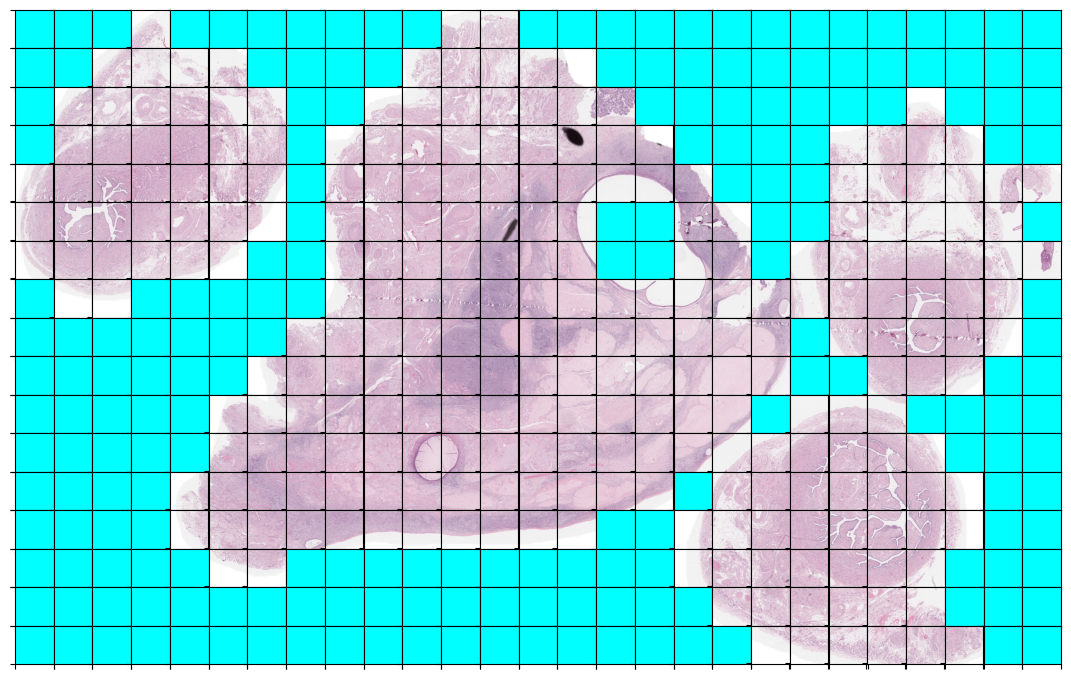

In [4]:
names = [os.path.splitext(os.path.basename(p_img))[0] for p_img in tiles_img]
pos = [name.split("_")[-1] for name in names]
idx_x, idx_y = zip(*[list(map(int, p.split("-"))) for p in pos])
nb_rows = len(set(idx_y))
nb_cols = len(set(idx_x))
print(f"{nb_rows=}\n{nb_cols=}")

fig, axes = plt.subplots(nrows=nb_rows, ncols=nb_cols,
    figsize=(nb_cols * 0.5, nb_rows * 0.5)
)
for i in range(nb_rows):
    for j in range(nb_cols):
        axes[i, j].set_facecolor("aqua")
        axes[i, j].set_xticklabels([])
        axes[i, j].set_yticklabels([])

for p_img, x, y in zip(tiles_img, idx_x, idx_y):
    img = plt.imread(p_img)
    ax = axes[y - 1, x - 1]
    ax.imshow(img)
print(f"image size: {img.shape}")

plt.subplots_adjust(wspace=0, hspace=0)
# # fig.tight_layout()

## Export all image tiles¶

In [ ]:
ls = glob.glob(os.path.join(DATASET_IMAGES, '*.png'))
print(f"found images: {len(ls)}")

# for id_pimg in tqdm(enumerate(ls)):
#     extract_prune_tiles(id_pimg, "train_tiles, size=1024, scale=0.1, max_samples=0.7)

pool = mproc.Pool(3)
tqdm_bar = tqdm(total=len(ls))
for _ in pool.imap_unordered(extract_prune_tiles, enumerate(ls)):
    tqdm_bar.update()
pool.close()
pool.join()

# _= Parallel(n_jobs=4)(
#     delayed(extract_prune_tiles)
#     (id_pimg, "train_tiles", size=1600, scale=0.15, drop_thr=0.8)
#     for id_pimg in tqdm(enumerate(ls))
# )

## Show some samples

found folders: 538
found images: 193419


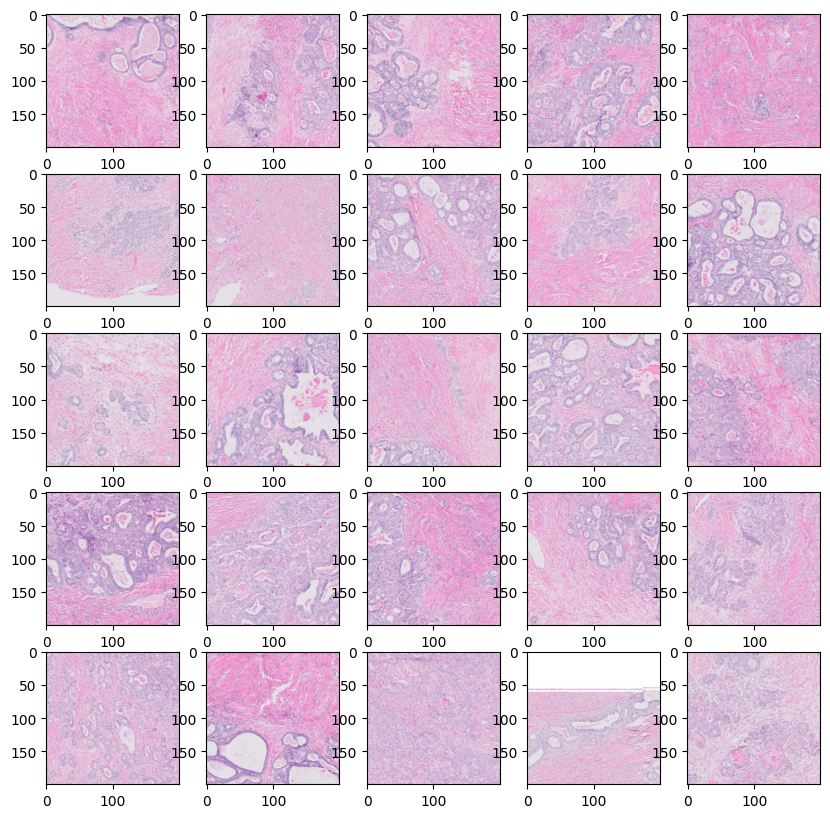

In [8]:
ls = [p for p in glob.glob('train_tiles/*') if os.path.isdir(p)]
print(f"found folders: {len(ls)}")
ls = glob.glob('train_tiles/*/*.png')
print(f"found images: {len(ls)}")

fig, axes = plt.subplots(nrows=5, ncols=5, figsize=(10, 10))
for i, p_img in enumerate(ls[:25]):
    img = plt.imread(p_img)
    ax = axes[i // 5, i % 5]
    ax.imshow(img)
    ax.set_axis_off()